In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, log, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder \
    .appName("StockMarketAnalysis") \
    .getOrCreate()

In [2]:
import yfinance as yf
import pandas as pd

# 1. Define tickers by sector

tech_tickers = ['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'HCLTECH.NS', 'TECHM.NS']
auto_tickers = ['BAJAJHLDNG.NS', 'LT.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'BAJAJ-AUTO.NS', 'EICHERMOT.NS', 'M&M.NS']
bank_tickers = ['HDFCBANK.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS', 'AXISBANK.NS']
pharma_tickers = ['SUNPHARMA.NS', 'CIPLA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'ABBOTINDIA.NS']
defense_tickers = ['GRSE.NS', 'HAL.NS', 'BEL.NS']

all_tickers = tech_tickers + auto_tickers + bank_tickers + pharma_tickers + defense_tickers


# 2. Set date range

start_date = "2020-01-01"
end_date   = "2025-10-05"


# 3. Download data

data = yf.download(all_tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False, progress=True)


# 4. Reshape to tidy format

records = []

for ticker in all_tickers:
    if ticker in data.columns.levels[0]:  # skip failed downloads
        df = data[ticker].copy()
        df['Ticker'] = ticker
        df = df.reset_index()  # make Date a column
        records.append(df)

# Combine all tickers into one tidy DataFrame
tidy_data = pd.concat(records, ignore_index=True)

# Optional: reorder columns
tidy_data = tidy_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']]


# 5. Save to CSV

tidy_data.to_csv('multi_sector_stock_data.csv', index=False)
print("Data saved to 'multi_sector_stock_data.csv'.")


[*********************100%***********************]  25 of 25 completed


Data saved to 'multi_sector_stock_data.csv'.


In [3]:
# Load your tidy CSV saved from yfinance
df = spark.read.csv('multi_sector_stock_data.csv', header=True, inferSchema=True)

# Check schema and preview
df.printSchema()
df.show(5)


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Ticker: string (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+------------------+---------+------+
|      Date|             Open|             High|              Low|            Close|         Adj Close|   Volume|Ticker|
+----------+-----------------+-----------------+-----------------+-----------------+------------------+---------+------+
|2020-01-01|           2168.0| 2183.89990234375|           2154.0| 2167.60009765625|   1907.1240234375|1354908.0|TCS.NS|
|2020-01-02|2179.949951171875|2179.949951171875|2149.199951171875| 2157.64990234375|  1898.36962890625|2380752.0|TCS.NS|
|2020-01-03|           2164.0|           2223.0|           2164.0| 2200.64990234375|1936.20251

In [4]:
from pyspark.sql.functions import to_date

df = df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))
# Fill numeric columns with 0 if missing
df = df.na.fill({
    'Open': 0,
    'High': 0,
    'Low': 0,
    'Close': 0,
    'Adj Close': 0,
    'Volume': 0
})

# Optional: drop rows with missing Date or Ticker
df = df.dropna(subset=['Date', 'Ticker'])



In [7]:
# Daily return
df['Return'] = df.groupby('Ticker')['Close'].pct_change()

# 5-day rolling mean
df['MA_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(5).mean())

# 10-day rolling volatility
df['Vol_10'] = df.groupby('Ticker')['Return'].transform(lambda x: x.rolling(10).std())

# Map sector
sector_map = {t: 'Tech' for t in tech_tickers}
sector_map.update({t: 'Auto' for t in auto_tickers})
sector_map.update({t: 'Bank' for t in bank_tickers})
sector_map.update({t: 'Pharma' for t in pharma_tickers})
sector_map.update({t: 'Defense' for t in defense_tickers})

df['Sector'] = df['Ticker'].map(sector_map)


TypeError: 'GroupedData' object is not subscriptable

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col

# Window partitioned by Ticker and ordered by Date
w = Window.partitionBy('Ticker').orderBy('Date')

# Previous day's close
df = df.withColumn('Prev_Close', lag('Close').over(w))

# Daily return = (Close - Prev_Close) / Prev_Close
df = df.withColumn('Return', (col('Close') - col('Prev_Close')) / col('Prev_Close'))


In [6]:
from pyspark.sql.functions import avg

df = df.withColumn('MA_5', avg('Close').over(w.rowsBetween(-4, 0)))   # 5-day
df = df.withColumn('MA_10', avg('Close').over(w.rowsBetween(-9, 0)))  # 10-day


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, avg, stddev, when
from pyspark.sql.window import Window


# 1. Initialize Spark

spark = SparkSession.builder \
    .appName("StockMarketAnalysis") \
    .getOrCreate()


# 2. Load data

df = spark.read.csv('multi_sector_stock_data.csv', header=True, inferSchema=True)

# Ensure Date is proper date type
from pyspark.sql.functions import to_date
df = df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Fill missing numeric values
df = df.na.fill({
    'Open': 0,
    'High': 0,
    'Low': 0,
    'Close': 0,
    'Adj Close': 0,
    'Volume': 0
})

# Drop rows with missing essential fields
df = df.dropna(subset=['Date', 'Ticker'])


# 3. Map sector

tech_tickers = ['TCS.NS', 'INFY.NS', 'WIPRO.NS', 'HCLTECH.NS', 'TECHM.NS']
auto_tickers = ['BAJAJHLDNG.NS', 'LT.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'BAJAJ-AUTO.NS', 'EICHERMOT.NS', 'M&M.NS']
bank_tickers = ['HDFCBANK.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS', 'AXISBANK.NS']
pharma_tickers = ['SUNPHARMA.NS', 'CIPLA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'ABBOTINDIA.NS']
defense_tickers = ['GRSE.NS', 'HAL.NS', 'BEL.NS']

df = df.withColumn(
    'Sector',
    when(col('Ticker').isin(tech_tickers), 'Tech')
    .when(col('Ticker').isin(auto_tickers), 'Auto')
    .when(col('Ticker').isin(bank_tickers), 'Bank')
    .when(col('Ticker').isin(pharma_tickers), 'Pharma')
    .when(col('Ticker').isin(defense_tickers), 'Defense')
    .otherwise('Unknown')
)


# 4. Define window per Ticker

w = Window.partitionBy('Ticker').orderBy('Date')

# Previous day's close
df = df.withColumn('Prev_Close', lag('Close').over(w))


# 5. Calculate Daily Return safely

df = df.withColumn(
    'Return',
    when(col('Prev_Close') != 0, (col('Close') - col('Prev_Close')) / col('Prev_Close'))
    .otherwise(None)  # safe NULL for first day
)


# 6. Calculate Moving Averages

df = df.withColumn('MA_5', avg('Close').over(w.rowsBetween(-4, 0)))   # 5-day
df = df.withColumn('MA_10', avg('Close').over(w.rowsBetween(-9, 0)))  # 10-day


# 7. Calculate Rolling Volatility

df = df.withColumn('Vol_10', stddev('Return').over(w.rowsBetween(-9, 0)))  # 10-day rolling std


# 8. Preview

df.show(10)
df.printSchema()


+----------+----------------+----------------+----------------+----------------+----------------+-------+-------------+------+----------------+--------------------+------------------+------------------+--------------------+
|      Date|            Open|            High|             Low|           Close|       Adj Close| Volume|       Ticker|Sector|      Prev_Close|              Return|              MA_5|             MA_10|              Vol_10|
+----------+----------------+----------------+----------------+----------------+----------------+-------+-------------+------+----------------+--------------------+------------------+------------------+--------------------+
|2020-01-01| 13170.599609375| 13452.150390625|         13080.0|         13140.0| 12056.119140625| 4037.0|ABBOTINDIA.NS|Pharma|            NULL|                NULL|           13140.0|           13140.0|                NULL|
|2020-01-02|13119.9501953125| 13314.900390625|13119.9501953125| 13139.900390625|  12056.02734375| 3435.0

C:\Python 3.11\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


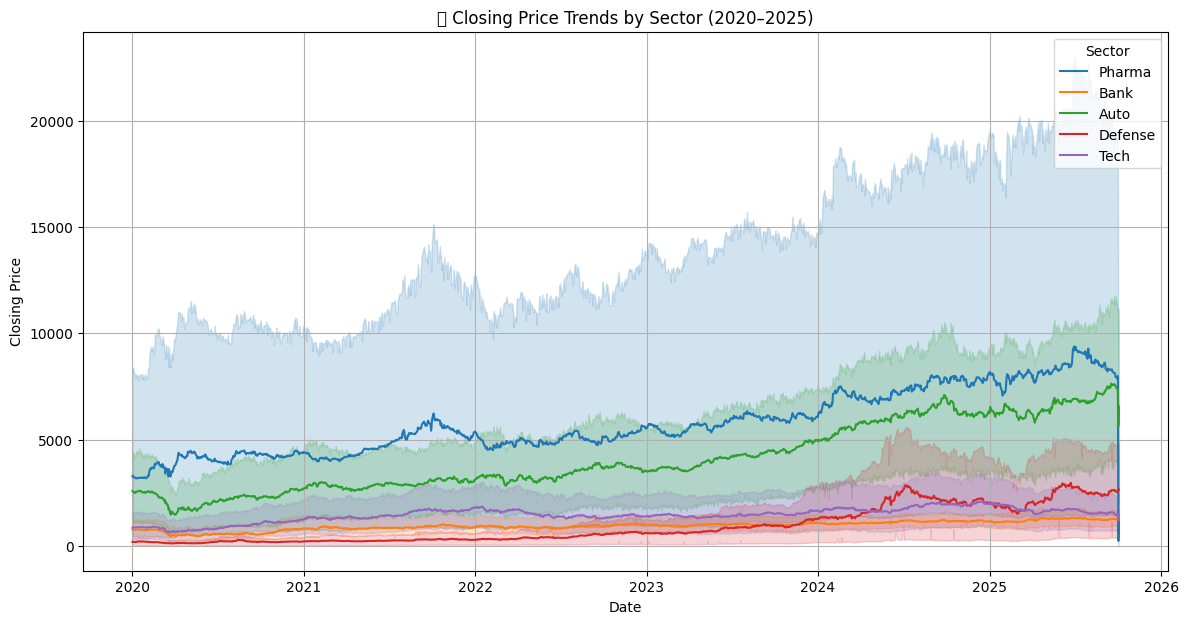

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1Convert small sample to Pandas for visualization
pdf = df.toPandas()

# Drop rows with missing values in key fields
pdf = pdf.dropna(subset=['Date', 'Close', 'MA_5', 'MA_10', 'Return'])

# 2️⃣ Plot closing price trends for each sector
plt.figure(figsize=(14, 7))
sns.lineplot(data=pdf, x='Date', y='Close', hue='Sector')
plt.title('📈 Closing Price Trends by Sector (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

C:\Python 3.11\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


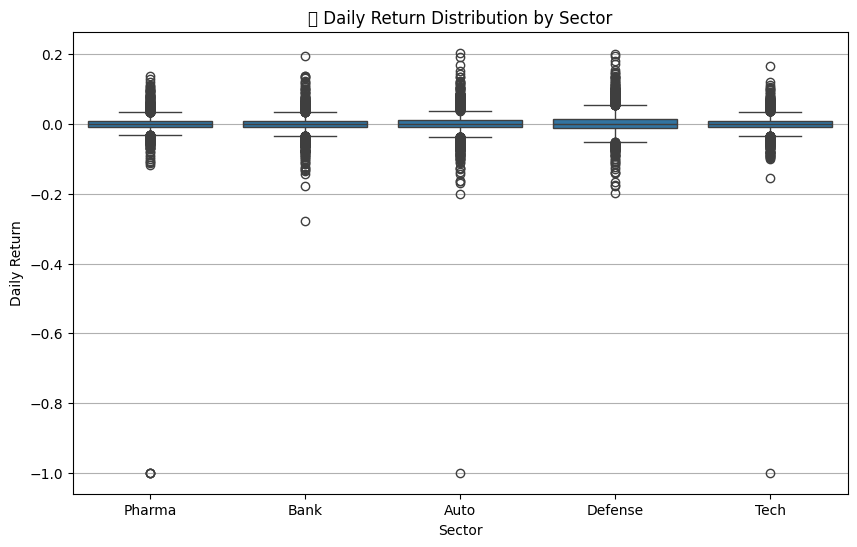

In [12]:
# Daily Returns Distribution by Sector
plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf, x='Sector', y='Return')
plt.title('📊 Daily Return Distribution by Sector')
plt.xlabel('Sector')
plt.ylabel('Daily Return')
plt.grid(True, axis='y')
plt.show()

C:\Users\vivek\AppData\Local\Temp\ipykernel_16396\2232423393.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vol_df, x='Sector', y='Vol_10', palette='viridis')


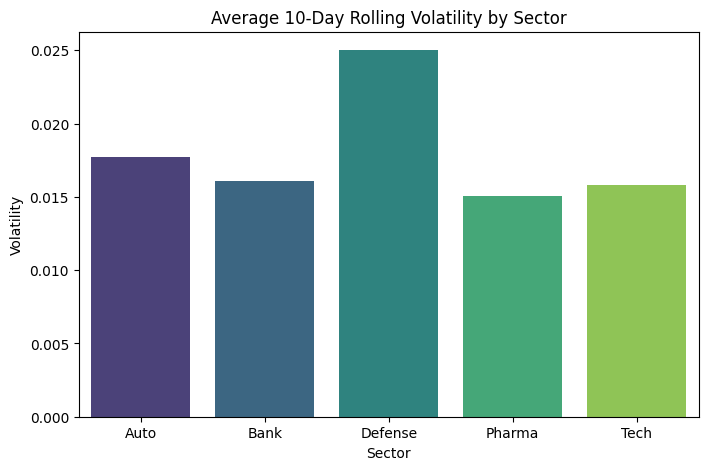

In [13]:
#  Average Volatility by Sector
vol_df = pdf.groupby('Sector')['Vol_10'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=vol_df, x='Sector', y='Vol_10', palette='viridis')
plt.title('Average 10-Day Rolling Volatility by Sector')
plt.xlabel('Sector')
plt.ylabel('Volatility')
plt.show()

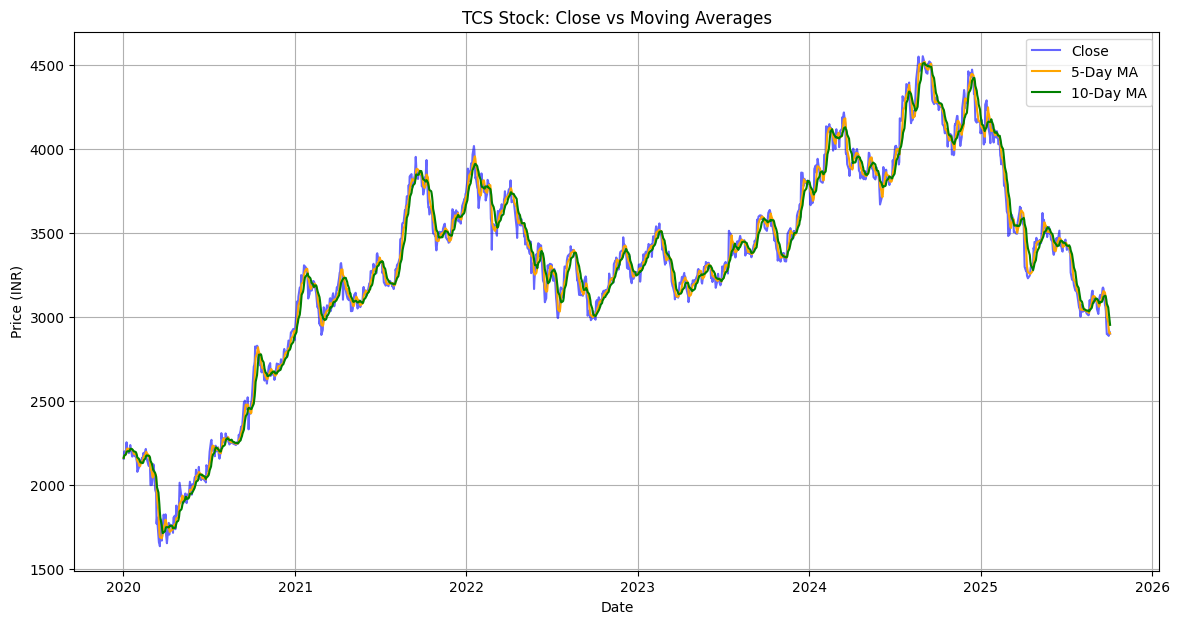

In [14]:
 # Plot moving averages for one sample company (e.g., TCS)
tcs_df = pdf[pdf['Ticker'] == 'TCS.NS']

plt.figure(figsize=(14, 7))
plt.plot(tcs_df['Date'], tcs_df['Close'], label='Close', color='blue', alpha=0.6)
plt.plot(tcs_df['Date'], tcs_df['MA_5'], label='5-Day MA', color='orange')
plt.plot(tcs_df['Date'], tcs_df['MA_10'], label='10-Day MA', color='green')
plt.title('TCS Stock: Close vs Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

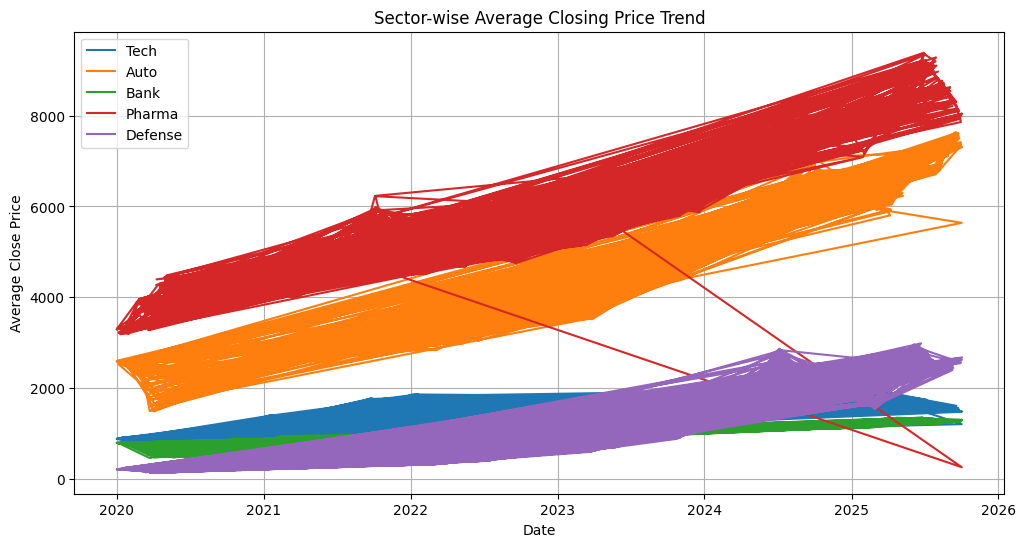

In [15]:
# Average closing price per sector per date
sector_trend = df.groupBy("Sector", "Date").avg("Close").withColumnRenamed("avg(Close)", "Avg_Close")

# Convert to pandas
pdf_sector = sector_trend.toPandas()

plt.figure(figsize=(12, 6))
for sector in pdf_sector['Sector'].unique():
    data = pdf_sector[pdf_sector['Sector'] == sector]
    plt.plot(data['Date'], data['Avg_Close'], label=sector)

plt.title("Sector-wise Average Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Average Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import pandas as pd
import plotly.express as px
from ipywidgets import interact

# Load your combined dataset
tidy_data = pd.read_csv("multi_sector_stock_data.csv")

# --- Sector mapping ---
sector_map = {
    'TCS.NS': 'Tech', 'INFY.NS': 'Tech', 'WIPRO.NS': 'Tech', 'HCLTECH.NS': 'Tech', 'TECHM.NS': 'Tech',
    'BAJAJHLDNG.NS': 'Auto', 'LT.NS': 'Auto', 'MARUTI.NS': 'Auto', 'TATAMOTORS.NS': 'Auto', 
    'BAJAJ-AUTO.NS': 'Auto', 'EICHERMOT.NS': 'Auto', 'M&M.NS': 'Auto',
    'HDFCBANK.NS': 'Bank', 'ICICIBANK.NS': 'Bank', 'KOTAKBANK.NS': 'Bank', 'SBIN.NS': 'Bank', 'AXISBANK.NS': 'Bank',
    'SUNPHARMA.NS': 'Pharma', 'CIPLA.NS': 'Pharma', 'DIVISLAB.NS': 'Pharma', 'DRREDDY.NS': 'Pharma', 'ABBOTINDIA.NS': 'Pharma',
    'GRSE.NS': 'Defense', 'HAL.NS': 'Defense', 'BEL.NS': 'Defense'
}

tidy_data['Sector'] = tidy_data['Ticker'].map(sector_map)

# --- Convert Date column to datetime ---
tidy_data['Date'] = pd.to_datetime(tidy_data['Date'])

# --- Interactive sector selection ---
def plot_sector(sector):
    df_sector = tidy_data[tidy_data['Sector'] == sector]
    fig = px.line(df_sector,
                  x='Date',
                  y='Close',
                  color='Ticker',
                  title=f'{sector} Sector - Stock Close Prices (2020–2025)',
                  labels={'Close': 'Closing Price', 'Date': 'Date', 'Ticker': 'Company'},
                  template='plotly_dark')
    fig.update_layout(legend_title_text='Company',
                      hovermode='x unified',
                      title_x=0.5,
                      title_font=dict(size=22))
    fig.show()

# --- Create dropdown for interactivity ---
interact(plot_sector, sector=['Tech', 'Auto', 'Bank', 'Pharma', 'Defense'])


interactive(children=(Dropdown(description='sector', options=('Tech', 'Auto', 'Bank', 'Pharma', 'Defense'), va…

<function __main__.plot_sector(sector)>

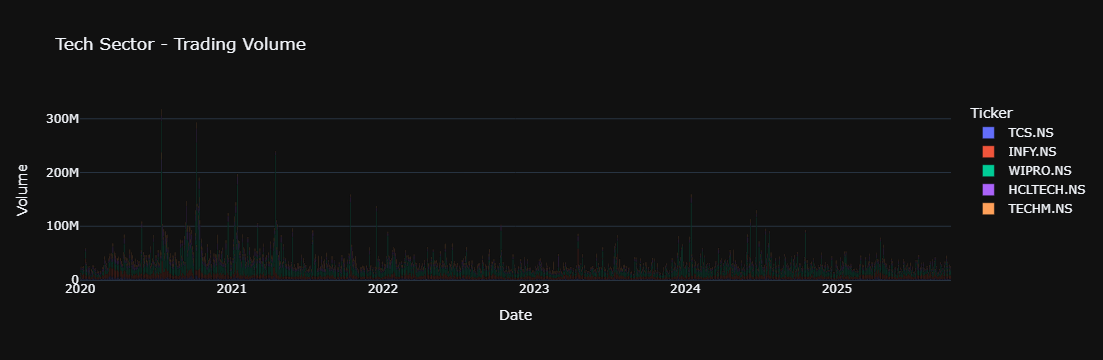

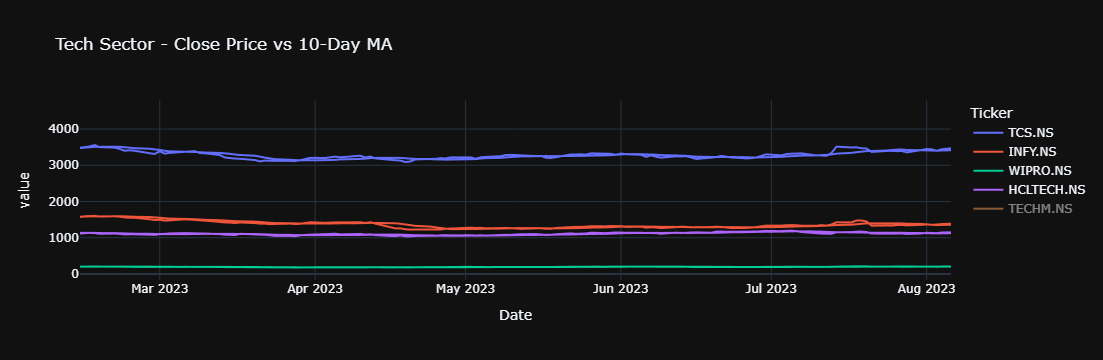

In [16]:
import pandas as pd
import plotly.express as px

# Load the saved tidy dataset
tidy_data = pd.read_csv("multi_sector_stock_data.csv")

# Map sectors again
sector_map = {
    'TCS.NS': 'Tech', 'INFY.NS': 'Tech', 'WIPRO.NS': 'Tech', 'HCLTECH.NS': 'Tech', 'TECHM.NS': 'Tech',
    'BAJAJHLDNG.NS': 'Auto', 'LT.NS': 'Auto', 'MARUTI.NS': 'Auto', 'TATAMOTORS.NS': 'Auto',
    'BAJAJ-AUTO.NS': 'Auto', 'EICHERMOT.NS': 'Auto', 'M&M.NS': 'Auto',
    'HDFCBANK.NS': 'Bank', 'ICICIBANK.NS': 'Bank', 'KOTAKBANK.NS': 'Bank', 'SBIN.NS': 'Bank', 'AXISBANK.NS': 'Bank',
    'SUNPHARMA.NS': 'Pharma', 'CIPLA.NS': 'Pharma', 'DIVISLAB.NS': 'Pharma', 'DRREDDY.NS': 'Pharma', 'ABBOTINDIA.NS': 'Pharma',
    'GRSE.NS': 'Defense', 'HAL.NS': 'Defense', 'BEL.NS': 'Defense'
}

tidy_data['Sector'] = tidy_data['Ticker'].map(sector_map)
tidy_data['Date'] = pd.to_datetime(tidy_data['Date'])

#  Define which sector you want to visualize
selected_sector = 'Tech'  # try 'Auto', 'Bank', etc.

df_sector = tidy_data[tidy_data['Sector'] == selected_sector].copy()

# ---  Volume Visualization ---
fig1 = px.bar(df_sector, 
              x='Date', 
              y='Volume', 
              color='Ticker', 
              title=f"{selected_sector} Sector - Trading Volume", 
              template='plotly_dark')
fig1.show()

# ---  Add Moving Average Overlay (Close + MA10) ---
df_sector['MA_10'] = df_sector.groupby('Ticker')['Close'].transform(lambda x: x.rolling(10).mean())

fig2 = px.line(df_sector, 
               x='Date', 
               y=['Close', 'MA_10'], 
               color='Ticker', 
               title=f"{selected_sector} Sector - Close Price vs 10-Day MA", 
               template='plotly_dark')
fig2.show()


In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, avg, when
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


#  Create Spark session

spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()


# Load the CSV generated earlier

df = spark.read.csv("multi_sector_stock_data.csv", header=True, inferSchema=True)

# Clean + ensure Date format
from pyspark.sql.functions import to_date
df = df.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Drop nulls
df = df.dropna(subset=['Date', 'Ticker', 'Close'])


#  Feature Engineering

w = Window.partitionBy('Ticker').orderBy('Date')

# Lag features
df = df.withColumn('Prev_Close', lag('Close', 1).over(w))
df = df.withColumn('Prev_Volume', lag('Volume', 1).over(w))

# Moving averages (5-day and 10-day)
df = df.withColumn('MA_5', avg('Close').over(w.rowsBetween(-4, 0)))
df = df.withColumn('MA_10', avg('Close').over(w.rowsBetween(-9, 0)))

# Daily return = (Close - Prev_Close) / Prev_Close (use safe divide)
df = df.withColumn(
    'Return',
    when(col('Prev_Close') != 0, (col('Close') - col('Prev_Close')) / col('Prev_Close')).otherwise(0)
)

# Drop nulls generated by lag
df = df.na.drop()


# Assemble features

feature_cols = ['Prev_Close', 'Prev_Volume', 'MA_5', 'MA_10', 'Return']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)


# Split train/test

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


# Train Random Forest Regressor

rf = RandomForestRegressor(featuresCol='features', labelCol='Close', numTrees=200, maxDepth=10)
model = rf.fit(train_df)


#  Predictions + Evaluation

predictions = model.transform(test_df)

evaluator_rmse = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f" Model Performance:")
print(f"   RMSE: {rmse:.4f}")
print(f"   R²  : {r2:.4f}")


 Model Performance:
   RMSE: 680.0317
   R²  : 0.9805


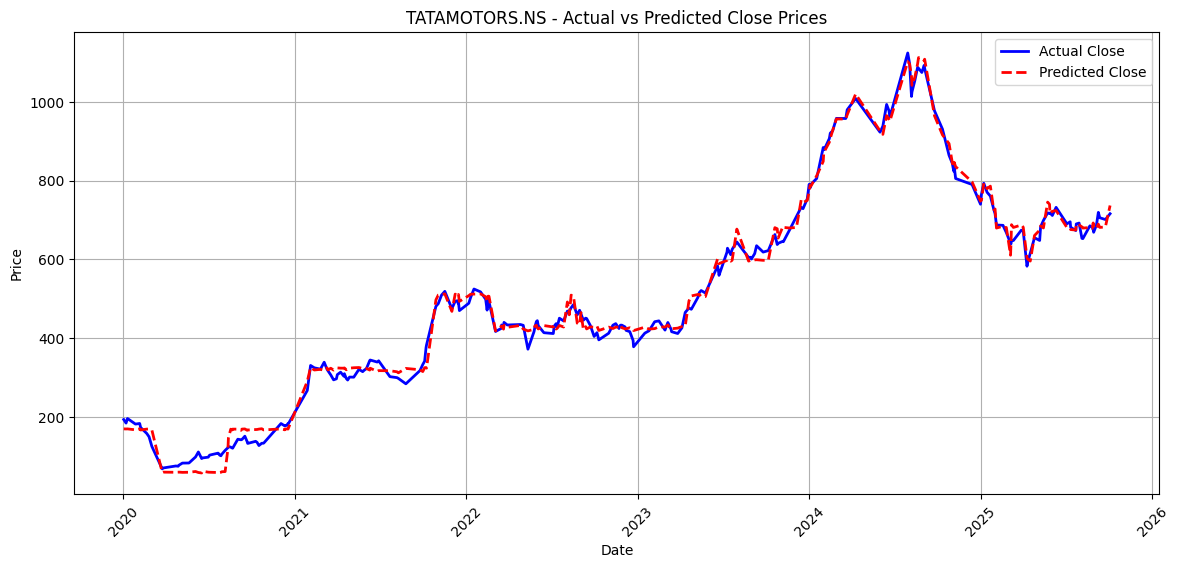

In [3]:
import matplotlib.pyplot as plt


# Convert to Pandas for plotting

# Choose a ticker
ticker_to_plot = 'TATAMOTORS.NS'
plot_df = predictions.filter(col('Ticker') == ticker_to_plot).select('Date', 'Close', 'prediction')
plot_pd = plot_df.toPandas()

# Ensure sorted by Date
plot_pd = plot_pd.sort_values('Date')


# Plot actual vs predicted

plt.figure(figsize=(14,6))
plt.plot(plot_pd['Date'], plot_pd['Close'], label='Actual Close', color='blue', linewidth=2)
plt.plot(plot_pd['Date'], plot_pd['prediction'], label='Predicted Close', color='red', linewidth=2, linestyle='--')
plt.title(f'{ticker_to_plot} - Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


GBT Model RMSE: 912.48, R²: 0.964


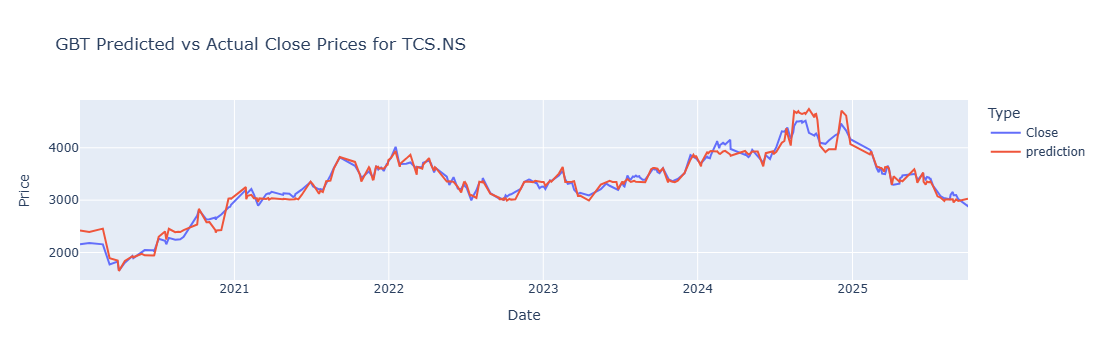

In [6]:
# --- FULL STOCK PREDICTION PIPELINE USING GBTREGRESSOR ---

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, avg, stddev
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark
spark = SparkSession.builder \
    .appName("StockMarket_GBT") \
    .getOrCreate()

# Load tidy CSV dataset
tidy_data = pd.read_csv("multi_sector_stock_data.csv")
tidy_data['Date'] = pd.to_datetime(tidy_data['Date'])

# Map sectors
sector_map = {
    'TCS.NS': 'Tech', 'INFY.NS': 'Tech', 'WIPRO.NS': 'Tech', 'HCLTECH.NS': 'Tech', 'TECHM.NS': 'Tech',
    'BAJAJHLDNG.NS': 'Auto', 'LT.NS': 'Auto', 'MARUTI.NS': 'Auto', 'TATAMOTORS.NS': 'Auto',
    'BAJAJ-AUTO.NS': 'Auto', 'EICHERMOT.NS': 'Auto', 'M&M.NS': 'Auto',
    'HDFCBANK.NS': 'Bank', 'ICICIBANK.NS': 'Bank', 'KOTAKBANK.NS': 'Bank', 'SBIN.NS': 'Bank', 'AXISBANK.NS': 'Bank',
    'SUNPHARMA.NS': 'Pharma', 'CIPLA.NS': 'Pharma', 'DIVISLAB.NS': 'Pharma', 'DRREDDY.NS': 'Pharma', 'ABBOTINDIA.NS': 'Pharma',
    'GRSE.NS': 'Defense', 'HAL.NS': 'Defense', 'BEL.NS': 'Defense'
}
tidy_data['Sector'] = tidy_data['Ticker'].map(sector_map)

# Convert to Spark DataFrame
df = spark.createDataFrame(tidy_data)

# Feature Engineering
windowSpec = Window.partitionBy("Ticker").orderBy("Date")

# Previous day's Close and Volume
df = df.withColumn("Prev_Close", lag("Close", 1).over(windowSpec))
df = df.withColumn("Prev_Volume", lag("Volume", 1).over(windowSpec))

# Moving Averages
df = df.withColumn("MA_5", avg("Close").over(windowSpec.rowsBetween(-4, 0)))
df = df.withColumn("MA_10", avg("Close").over(windowSpec.rowsBetween(-9, 0)))
df = df.withColumn("MA_20", avg("Close").over(windowSpec.rowsBetween(-19, 0)))

# Volatility
df = df.withColumn("Volatility_5", stddev("Close").over(windowSpec.rowsBetween(-4, 0)))

# Daily Returns
df = df.withColumn("Return", (col("Close") - col("Prev_Close")) / col("Prev_Close"))

# Fill nulls
df = df.na.fill(0)

# Assemble features
feature_cols = ['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Prev_Volume',
                'MA_5', 'MA_10', 'MA_20', 'Volatility_5', 'Return']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(df).select('Date', 'Ticker', 'Close', 'features')

# Train-Test Split
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

#  Gradient Boosted Trees Regressor
gbt = GBTRegressor(featuresCol='features', labelCol='Close', maxIter=100, maxDepth=5)
gbt_model = gbt.fit(train_df)

# Predictions
predictions = gbt_model.transform(test_df)

# Evaluate Model
evaluator = RegressionEvaluator(labelCol='Close', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName('r2').evaluate(predictions)
print(f"GBT Model RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Convert predictions to Pandas for visualization
preds_pd = predictions.toPandas()

# Example: visualize TCS.NS predictions
import plotly.express as px
company = "TCS.NS"
df_company = preds_pd[preds_pd['Ticker'] == company]

fig = px.line(df_company, x='Date', y=['Close', 'prediction'],
              title=f"GBT Predicted vs Actual Close Prices for {company}",
              labels={'value':'Price', 'variable':'Type'})
fig.show()


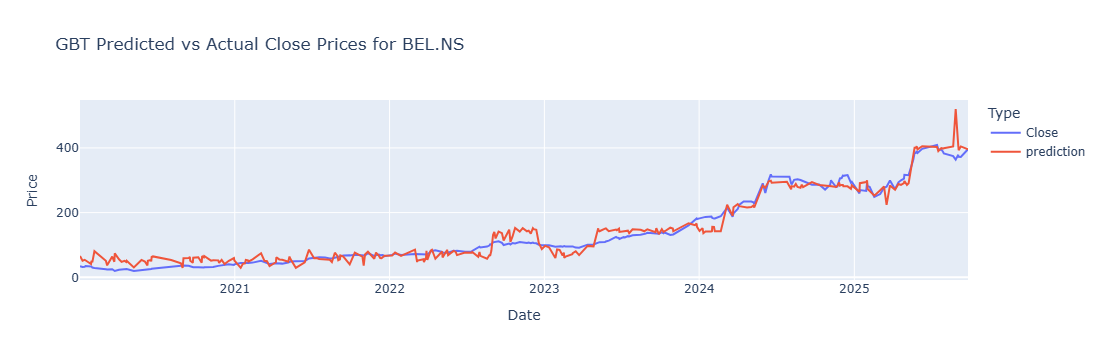

In [7]:
import plotly.express as px
company = "BEL.NS"
df_company = preds_pd[preds_pd['Ticker'] == company]

fig = px.line(df_company, x='Date', y=['Close', 'prediction'],
              title=f"GBT Predicted vs Actual Close Prices for {company}",
              labels={'value':'Price', 'variable':'Type'})
fig.show()